In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('INFO')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

In [3]:
import sys

In [4]:
sys.path.insert(1, "/home/gemeinl/code/braindecode_lazy/")

In [5]:
from braindecode_lazy.datasets.tuh_lazy import TuhLazy as Tuh

In [6]:
ds = Tuh("/home/gemeinl/data/pre_100_Hz_without_rejecting/train/", n_recordings=None)

In [7]:
len(ds)

2717

In [6]:
import torch

In [9]:
torch.__version__

'1.0.1.post2'

In [10]:
model = torch.load("../results/networks/deep/pathological/eval/model.pt")

In [11]:
model.cuda()

Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
  (conv_spat): Conv2d(25, 25, kernel_size=(1, 21), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=elu)
  (pool): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(3, 1), ceil_mode=False)
  (pool_nonlin): Expression(expression=identity)
  (drop_2): Dropout(p=0.5)
  (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), dilation=(3, 1), bias=False)
  (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin_2): Expression(expression=elu)
  (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(9, 1), ceil_mode=False)
  (pool_nonlin_2): Expression(expression=identity)
  (drop_3): Dropout(p=0.5)
  (conv_3): Conv2d(50, 100, kernel_size=(10, 1), stride=(1, 1), d

In [16]:
torch.backends.cudnn.benchmark = True

In [17]:
import numpy as np
from braindecode_lazy.datautil.iterators import LazyCropsFromTrialsIterator as CropsFromTrialsIterator
from braindecode.torch_ext.util import np_to_var
input_time_length = 6000
cuda = True
n_chans = 21
batch_size = 64
n_classes = 2
test_input = np_to_var(np.ones((n_classes, n_chans, input_time_length, 1),
                               dtype=np.float32))
if list(model.parameters())[0].is_cuda:
    test_input = test_input.cuda()
out = model(test_input)
n_preds_per_input = out.cpu().data.numpy().shape[2]

iterator = CropsFromTrialsIterator(input_time_length=input_time_length, n_preds_per_input=out.shape[2], batch_size=batch_size)

In [ ]:
from torch import nn
from braindecode.torch_ext.util import var_to_np
import torch as th
new_model = nn.Sequential()
for name, module in model.named_children():
    if name == 'softmax': break
    new_model.add_module(name, module)

new_model.eval();
pred_fn = lambda x: var_to_np(th.mean(new_model(np_to_var(x).cuda())[:,:,:,0], dim=2, keepdim=False))

In [19]:
from braindecode.visualization.perturbation import compute_amplitude_prediction_correlations

In [ ]:
n_iterations = 20
all_amp_pred_mean_and_cov = []
for i, (batch_X, batch_y) in enumerate(iterator.get_batches(ds, shuffle=False)):
    # make this return covariance and mean instead of correlations
    amp_pred_mean_and_cov = compute_amplitude_prediction_correlations(pred_fn, batch_X, n_iterations=n_iterations,
                                             batch_size=batch_size)
    all_amp_pred_mean_and_cov.append(amp_pred_mean_and_cov)

2019-07-01 17:42:05,148 INFO : Compute original predictions...
2019-07-01 17:42:05,637 INFO : Iteration 0...
2019-07-01 17:42:05,640 INFO : Sample perturbation...
2019-07-01 17:42:05,961 INFO : Compute perturbed complex inputs...
2019-07-01 17:42:06,220 INFO : Compute perturbed real inputs...
2019-07-01 17:42:06,274 INFO : Compute new predictions...
2019-07-01 17:42:06,391 INFO : Layer 0...
2019-07-01 17:42:06,408 INFO : Compute activation difference...
2019-07-01 17:42:06,410 INFO : Compute correlation...
2019-07-01 17:42:06,443 INFO : Iteration 1...
2019-07-01 17:42:06,445 INFO : Sample perturbation...
2019-07-01 17:42:06,747 INFO : Compute perturbed complex inputs...
2019-07-01 17:42:06,990 INFO : Compute perturbed real inputs...
2019-07-01 17:42:07,036 INFO : Compute new predictions...
2019-07-01 17:42:07,152 INFO : Layer 0...
2019-07-01 17:42:07,155 INFO : Compute activation difference...
2019-07-01 17:42:07,156 INFO : Compute correlation...
2019-07-01 17:42:07,191 INFO : Iteratio

In [ ]:
from copy import deepcopy

In [ ]:
backup = deepcopy(all_amp_pred_mean_and_cov)

In [21]:
all_amp_pred_mean_and_cov = np.array(all_amp_pred_mean_and_cov)

In [22]:
all_amp_pred_mean_and_cov.shape

(947, 21, 3001, 2)

np.save(arr=all_amp_pred_mean_and_cov, file="/home/gemeinl/results/all_recs_100_hz/networks/deep/pathological/eval/batched_amp_pred_corr_2.npy")

import numpy as np
all_amp_pred_mean_and_cov = np.load("/home/gemeinl/results/all_recs_100_hz/networks/deep/pathological/eval/batched_amp_pred_corr_2.npy")

## Plot correlations

Pick out one frequency range and mean correlations within that frequency range to make a scalp plot.
Here we use the alpha frequency range.

In [14]:
# pick those channels that are available in braindecode channel locations
stacked_all_amp_pred_mean_and_cov =  np.stack(np.array(all_amp_pred_mean_and_cov))

In [15]:
stacked_all_amp_pred_mean_and_cov.shape

(947, 21, 3001, 2)

In [16]:
# n_trials x n_channels x points x classes
# mean is not 100% clean but ok
stacked_all_amp_pred_mean_and_cov = np.mean(stacked_all_amp_pred_mean_and_cov, axis=0)
stacked_all_amp_pred_mean_and_cov.shape

(21, 3001, 2)

Now get approximate positions of the channels in the 10-20 system.

In [17]:
CHANNEL_10_20_APPROX = (
    "angle",
    ["A1", [-5, 0]],
    ["A2", [5, 0]],
        
    ["Fp1", [-3.500, 3.500]],
    ["Fp2", [3.500, 3.500]],

    ["F7", [-4.000, 2.000]],
    ["F3", [-2.000, 2.000]],
    ["Fz", [0.000, 2.000]],
    ["F4", [2.000, 2.000]],
    ["F8", [4.000, 2.000]],

    ["C3", [-2.000, 0.000]],
    ["Cz", [0.000, 0.000]],
    ["C4", [2.000, 0.000]],

    ["P3", [-2.000, -2.000]],
    ["Pz", [0.000, -2.000]],
    ["P4", [2.000, -2.000]],
    
    ["O1", [-3.5, -3.5]],
    ["O2", [3.5, -3.5]],
    
    ["T3", [-3.5, 0]],
    ["T5", [-3.5, -2]],
    ["T4", [3.5, 0]],
    ["T6", [3.5, -2]],
)

In [18]:
names = ['A1', 'A2', 'C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2',
       'Fz', 'O1', 'O2', 'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6']

In [19]:
ch_approx = CHANNEL_10_20_APPROX

In [20]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import mne

In [21]:
from braindecode.visualization.plot import ax_scalp

In [22]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [23]:
global_max_abs_val = True

fs = 100
input_time_length = 6000
freqs = np.fft.rfftfreq(input_time_length, d=1.0/fs)
freq_bands = [(0, 4), (4, 8), (8, 13), (13, 30), (30, 50)]
class_names = ['normal', 'pathological']

freq_corr_means = []
for (start_freq, stop_freq) in freq_bands:
    i_start = np.searchsorted(freqs, start_freq)
    i_stop = np.searchsorted(freqs, stop_freq) + 1

    freq_corr = np.mean(stacked_all_amp_pred_mean_and_cov[:,i_start:i_stop], axis=1)# * 100
    freq_corr_means.append(freq_corr)

if global_max_abs_val:
    max_abs_val = np.max(np.abs(freq_corr_means))

In [24]:
max_abs_val

0.005035717

In [26]:
i_class=1

/home/gemeinl/anaconda3/envs/braindecode/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


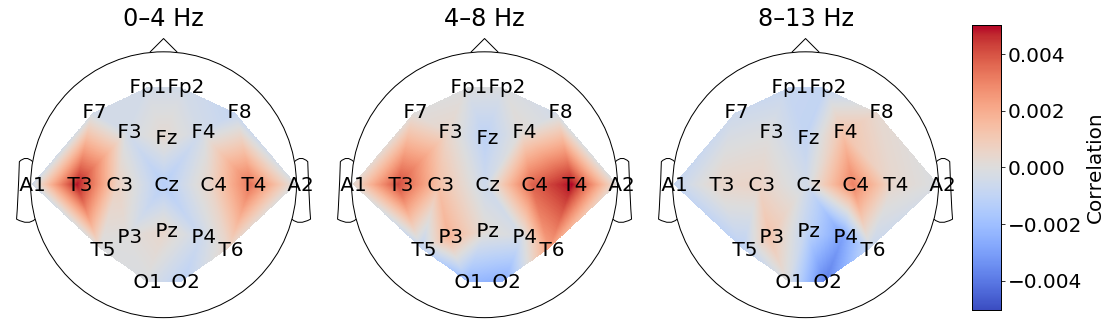

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(19.5,12))
plt.subplots_adjust(wspace=.05)
for i in range(0,3):
    freq_corr_mean = freq_corr_means[i]
    if not global_max_abs_val:
        max_abs_val = np.max(np.abs(freq_corr_mean))
    txt = "{}–{} Hz".format(freq_bands[i][0], freq_bands[i][1])
    ax = axes[i]
    im = ax_scalp(freq_corr_mean[:,i_class], names, chan_pos_list=ch_approx, cmap=cm.coolwarm,
             vmin=-max_abs_val, vmax=max_abs_val, ax=ax, annotate=True, fontsize=20)
    ax.set_title(txt)


    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.81, 0.35, 0.02, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)#, ticks=[-.5,-0.25, 0.0, 0.25, .5])
    #cbar.ax.set_ylabel("$10^{-2}$ * Correlation")
    cbar.ax.set_ylabel("Correlation")    

In [30]:
fig.savefig("./perturbation.tif", bbox_inches="tight")

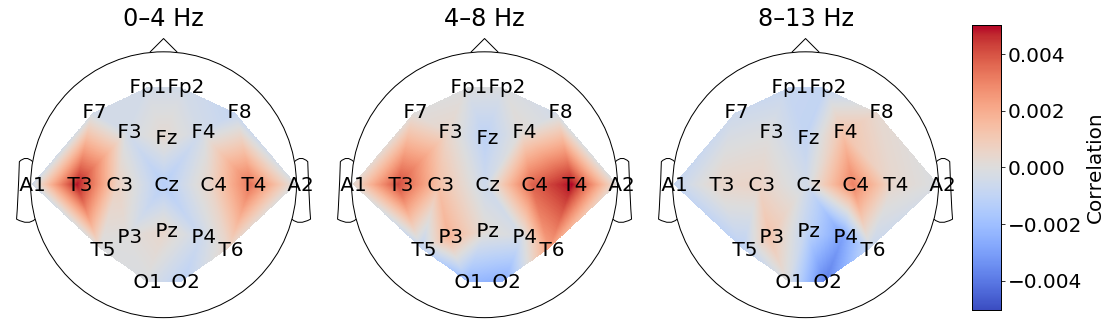

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(19.5,12))
plt.subplots_adjust(wspace=.05)
for i in range(0,3):
    freq_corr_mean = freq_corr_means[i]
    if not global_max_abs_val:
        max_abs_val = np.max(np.abs(freq_corr_mean))
    txt = "{}–{} Hz".format(freq_bands[i][0], freq_bands[i][1])
    ax = axes[i]
    im = ax_scalp(freq_corr_mean[:,i_class], names, chan_pos_list=ch_approx, cmap=cm.coolwarm,
             vmin=-max_abs_val, vmax=max_abs_val, ax=ax, annotate=True, fontsize=20)
    ax.set_title(txt)


    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.81, 0.35, 0.02, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)#, ticks=[-.5,-0.25, 0.0, 0.25, .5])
    #cbar.ax.set_ylabel("$10^{-2}$ * Correlation")
    cbar.ax.set_ylabel("Correlation")    

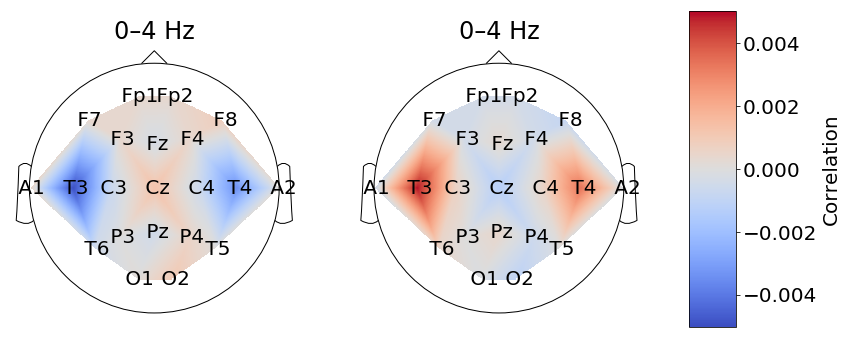

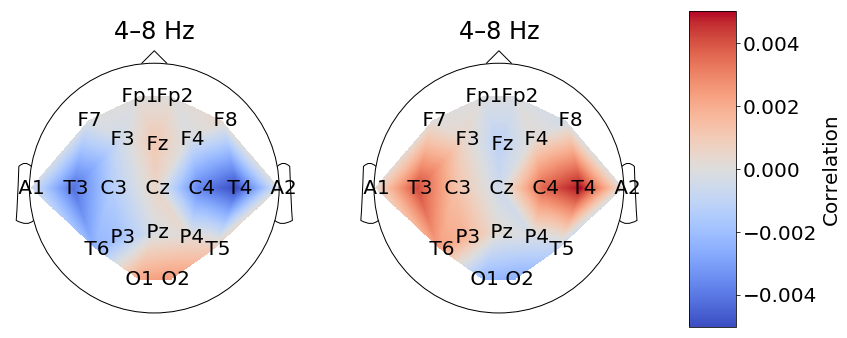

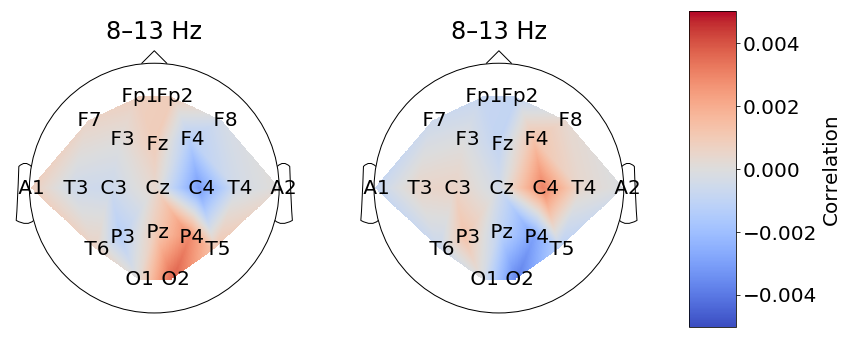

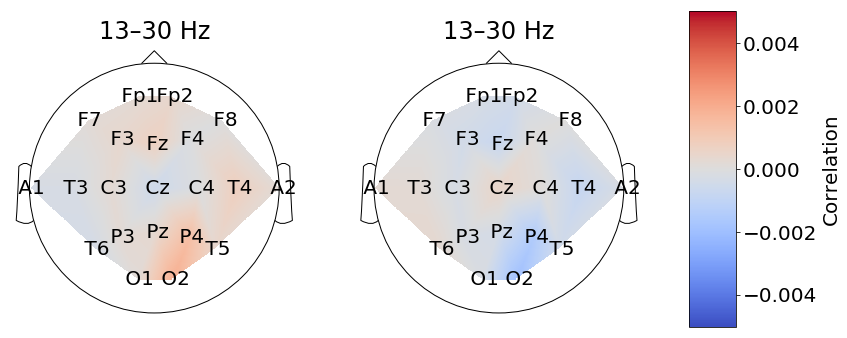

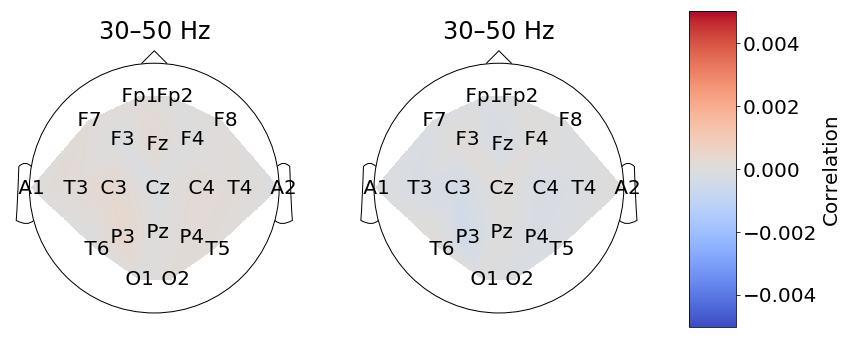

In [484]:
global_max_abs_val = True

fs = 100
freqs = np.fft.rfftfreq(input_time_length, d=1.0/fs)
freq_bands = [(0, 4), (4, 8), (8, 13), (13, 30), (30, 50)]
class_names = ['normal', 'pathological']

freq_corr_means = []
for (start_freq, stop_freq) in freq_bands:
    i_start = np.searchsorted(freqs, start_freq)
    i_stop = np.searchsorted(freqs, stop_freq) + 1

    freq_corr = np.mean(stacked_all_amp_pred_mean_and_cov[:,i_start:i_stop], axis=1)
    freq_corr_means.append(freq_corr)

if global_max_abs_val:
    max_abs_val = np.max(np.abs(freq_corr_means))
for i, freq_corr_mean in enumerate(freq_corr_means):
    if not global_max_abs_val:
        max_abs_val = np.max(np.abs(freq_corr_mean))
    fig, axes = plt.subplots(1, len(class_names), figsize=(13,8))
    txt = "{}–{} Hz".format(freq_bands[i][0], freq_bands[i][1])
    #fig.suptitle(txt, y=.85)
    for i_class in range(len(class_names)):
        if len(class_names) > 1:
            ax = axes[i_class]
        else:
            ax = axes
        im = ax_scalp(freq_corr_mean[:,i_class], names, chan_pos_list=ch_approx, cmap=cm.coolwarm,
                 vmin=-max_abs_val, vmax=max_abs_val, ax=ax, annotate=True, fontsize=20)
        #ax.set_title(class_names[i_class])
        ax.set_title(txt)


    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.55])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.set_ylabel("Correlation")